In [8]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D
from csbdeep.utils import Path, normalize
from tifffile import imread
from glob import glob
from tracking_utils import plot_img_label, random_fliprot, random_intensity_change, augmenter
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import
import tensorflow as tf
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
test_img = imread('./simulation/synthetic_dataset/image/synthetic_0.tif')
test_mask = imread('./simulation/synthetic_dataset/mask/synthetic_0.tif')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_img, cmap='gray')
ax[1].imshow(test_mask, cmap=lbl_cmap)
plt.show()

In [ ]:
X = sorted(glob("./simulation/synthetic_dataset/image/*.tif"))
Y = sorted(glob("./simulation/synthetic_dataset/mask/*.tif"))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

In [ ]:
training_model = 'pretrained_2D_versatile_fluo' # 'new'

if training_model == 'new':
    n_rays = 32
    use_gpu = False and gputools_available()
    grid = (2, 2)
    conf = Config2D (
        n_rays       = n_rays,
        grid         = grid,
        use_gpu      = use_gpu,
        n_channel_in = n_channel,
    )
    print(conf)
    vars(conf)
    if use_gpu:
        from csbdeep.utils.tf import limit_gpu_memory
        limit_gpu_memory(0.8)
    timestamp = time.time()
    model = StarDist2D(conf, name=f'stardist_trained', basedir='models')
    median_size = calculate_extents(list(Y), np.median)
    fov = np.array(model._axes_tile_overlap('YX'))
    print(f"median object size:      {median_size}")
    print(f"network field of view :  {fov}")
    if any(median_size > fov):
        print("WARNING: median object size larger than field of view of the neural network.")
    model.train(X_trn, Y_trn, validation_data=(X_val, Y_val), augmenter=augmenter, epochs=150, steps_per_epoch=100)
    model.optimize_thresholds(X_val, Y_val)

elif training_model == 'pretrained_2D_versatile_fluo':
    if 1:
        model_pretrained = StarDist2D.from_pretrained('2D_versatile_fluo')
        shutil.copytree(model_pretrained.logdir, './models/modified_2D_versatile_fluo', dirs_exist_ok=True)
        model = StarDist2D(None, './models/modified_2D_versatile_fluo')
    else:
        model = StarDist2D(None, name = 'modified_2D_versatile_fluo', \
                               basedir = 'models')

    median_size = calculate_extents(list(Y), np.median)
    fov = np.array(model._axes_tile_overlap('YX'))
    print(f"median object size:      {median_size}")
    print(f"network field of view :  {fov}")
    if any(median_size > fov):
        print("WARNING: median object size larger than field of view of the neural network.")
    model.train(X_trn, Y_trn, validation_data=(X_val, Y_val), augmenter=augmenter, epochs = 150, steps_per_epoch = 100)
    model.optimize_thresholds(X_val, Y_val)


In [5]:
epoch_prob_loss = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_prob_loss.csv')
epoch_dist_dist_iou_metric = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_dist_dist_iou_metric.csv')
epoch_dist_loss = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_dist_loss.csv')
epoch_dist_relevant_mae = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_dist_relevant_mae.csv')
epoch_dist_relevant_mse = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_dist_relevant_mse.csv')
epoch_loss = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_loss.csv')
epoch_lr = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_lr.csv')
epoch_prob_kld = pd.read_csv('./models/modified_2D_versatile_fluo/logs_csv/epoch_prob_kld.csv')

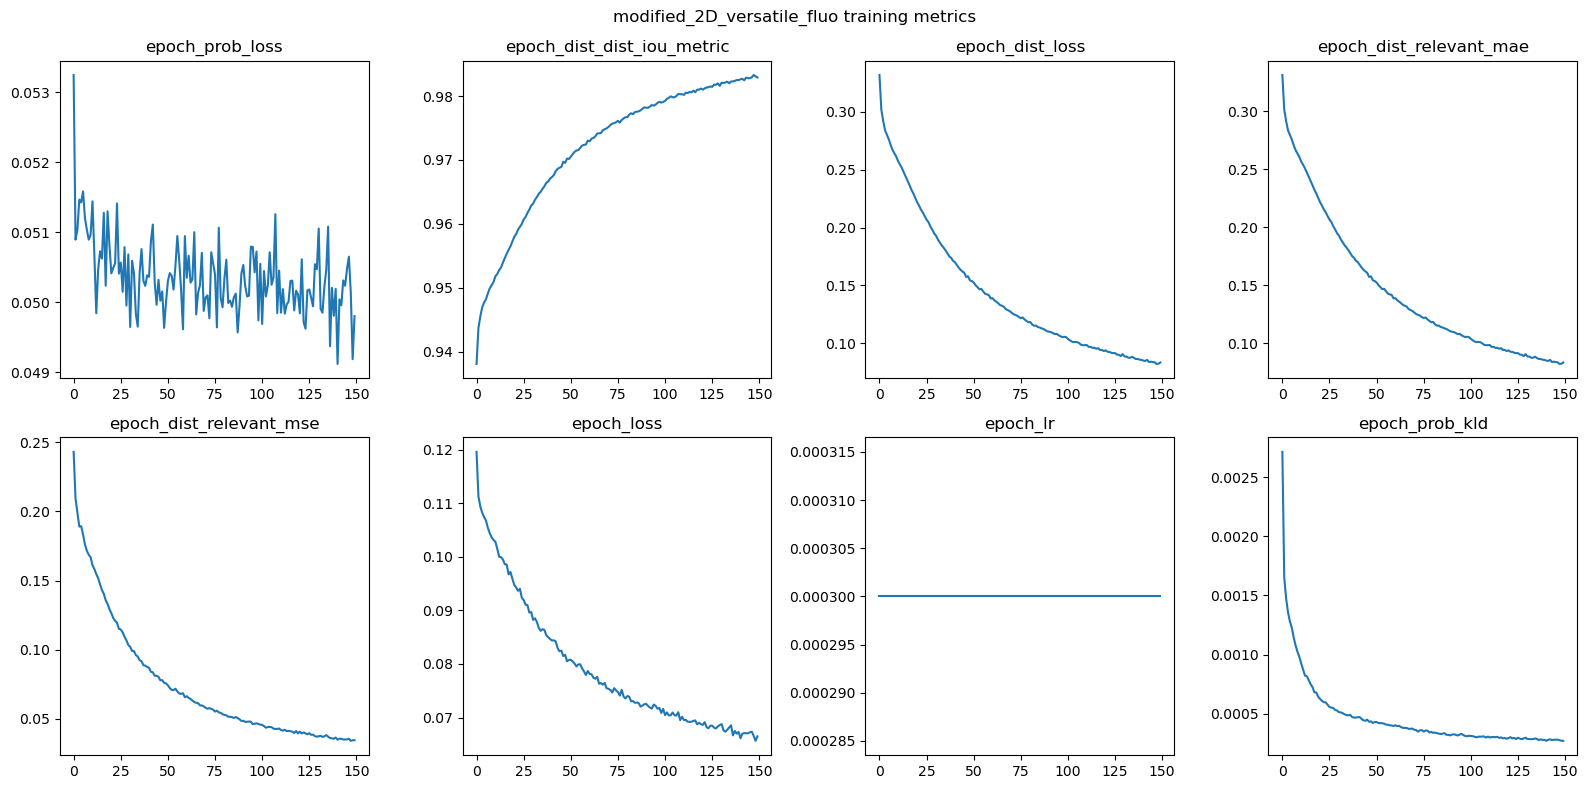

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].plot(epoch_prob_loss.Step, epoch_prob_loss.Value)
ax[0, 0].set_title('epoch_prob_loss')
ax[0, 1].plot(epoch_dist_dist_iou_metric.Step, epoch_dist_dist_iou_metric.Value)
ax[0, 1].set_title('epoch_dist_dist_iou_metric')
ax[0, 2].plot(epoch_dist_loss.Step, epoch_dist_loss.Value)
ax[0, 2].set_title('epoch_dist_loss')
ax[0, 3].plot(epoch_dist_relevant_mae.Step, epoch_dist_relevant_mae.Value)
ax[0, 3].set_title('epoch_dist_relevant_mae')
ax[1, 0].plot(epoch_dist_relevant_mse.Step, epoch_dist_relevant_mse.Value)
ax[1, 0].set_title('epoch_dist_relevant_mse')
ax[1, 1].plot(epoch_loss.Step, epoch_loss.Value)
ax[1, 1].set_title('epoch_loss')
ax[1, 2].plot(epoch_lr.Step, epoch_lr.Value)
ax[1, 2].set_title('epoch_lr')
ax[1, 3].plot(epoch_prob_kld.Step, epoch_prob_kld.Value)
ax[1, 3].set_title('epoch_prob_kld')
plt.suptitle('modified_2D_versatile_fluo training metrics')
plt.tight_layout()
plt.savefig('./models/modified_2D_versatile_fluo/training_metrics.png')
plt.show()